In [1]:
################################################################################################################################################
# Modelling gross private domestic investment (GPDI) from Federal Reserve Economic Datasets:
# Autoregressive integrated moving average (ARIMA) model for timeseries data: univariate time series model
################################################################################################################################################
# import libraries
import glob
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

In [2]:
########################################################################
# pre-processing: read in all files into dfs within a dict, clean and plot
########################################################################
folder="C:/Users/bcm9/Documents/Py_code/Data/FRED/"
filelist = glob.glob(os.path.join(folder, "*.xls"))
print(filelist)

['C:/Users/bcm9/Documents/Py_code/Data/FRED\\BOPGSTB.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\CPALTT01USM657N.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GDPC1.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\GPDI.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\PCECC96.xls', 'C:/Users/bcm9/Documents/Py_code/Data/FRED\\UNRATE.xls']


In [3]:
# create empty dictionary 
df_dict = {}

# append datasets into the list
for file in filelist:
    df = pd.read_excel(file)
    # get the name of the csv without the '.csv' extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df_dict[filename] = df

In [4]:
for key in df_dict.keys():
    df = df_dict[key]
    df = df.loc[10:, :].copy()
    df['date'] = pd.to_datetime(df['FRED Graph Observations'])
    df_dict[key] = df

In [5]:
# drop all original date format from df and rename columns for later identification
for key in df_dict.keys():
    df_dict[key] = df_dict[key].drop('FRED Graph Observations', axis=1)
    df_dict[key]=df_dict[key].rename(columns={"Unnamed: 1": key})

In [8]:
#############################################################################
# Build model
#############################################################################
ts = pd.Series(data=df_dict['GPDI']['GPDI'].values, index=pd.to_datetime(df_dict['GPDI']['date']))

print(ts)

# set hyperparameters
# p = n lag observations, to capture the dependence of current value on past values. high p = account for more past values
# d = degree of differencing used to make the time series data stationary
# q = size of the moving average window, capture dependence of the current value on past errors
p=1
d=1
q=1

# fit ARIMA model to the time series
model = sm.tsa.ARIMA(ts.astype(float), order=(p,d,q)).fit()

date
1947-01-01      35.854
1947-04-01      34.505
1947-07-01      34.911
1947-10-01       43.25
1948-01-01      47.202
                ...   
2021-10-01    4499.171
2022-01-01    4671.027
2022-04-01    4609.927
2022-07-01    4579.069
2022-10-01    4663.827
Length: 304, dtype: object


C:\Users\bcm9\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\bcm9\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\bcm9\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [9]:
# AIC and BIC values for model
print("AIC:", model.aic)
print("BIC:", model.bic)

AIC: 3431.6632641651877
BIC: 3442.8044625817156


In [10]:
# predictions for the next n time steps
nsteps=15
forecast = model.forecast(steps=nsteps)
print(forecast)

2023-01-01    4699.554590
2023-04-01    4735.205218
2023-07-01    4770.779051
2023-10-01    4806.276254
2024-01-01    4841.696992
2024-04-01    4877.041430
2024-07-01    4912.309732
2024-10-01    4947.502062
2025-01-01    4982.618585
2025-04-01    5017.659462
2025-07-01    5052.624857
2025-10-01    5087.514933
2026-01-01    5122.329852
2026-04-01    5157.069776
2026-07-01    5191.734866
Freq: QS-OCT, Name: predicted_mean, dtype: float64


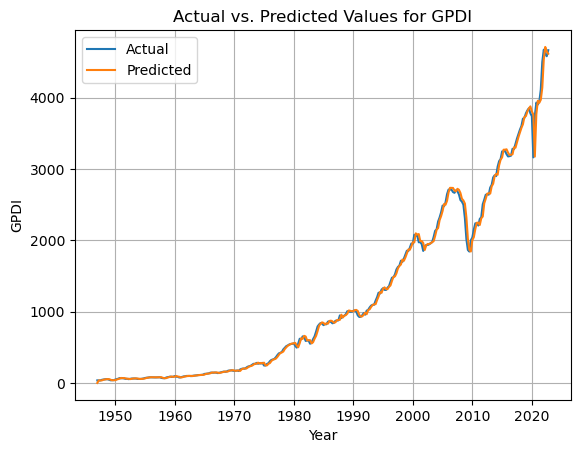

In [11]:
# plot actual time series data
plt.plot(ts.index, ts, label='Actual')

# plot prediction from ARIMA model
plt.plot(ts.index, model.fittedvalues, label='Predicted')

# formatting
plt.title('Actual vs. Predicted Values for GPDI')
plt.xlabel('Year')
plt.ylabel('GPDI')
plt.legend()
plt.grid()
plt.show()

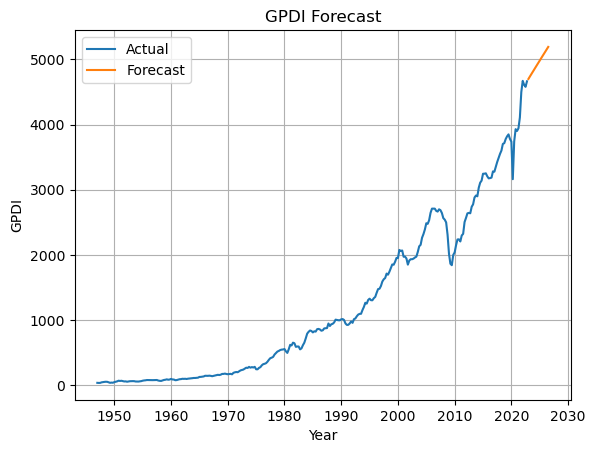

In [12]:
# plot forecast
plt.plot(ts.index, ts, label='Actual')
plt.plot(pd.date_range(start=ts.index[-1], periods=nsteps+1, freq='QS')[1:], forecast, label='Forecast')

# formatting, show
plt.legend()
plt.title('GPDI Forecast')
plt.xlabel('Year')
plt.ylabel('GPDI')
plt.grid()
plt.show()

In [15]:
#############################################################################
# auto-tune hyperparams with auto_arima
#############################################################################
# split data into training and testing sets
n_train = int(0.8 * len(ts))
train = ts[:n_train]
test = ts[n_train:]

# create auto_arima model, fit to training data, print
model = pm.auto_arima(train, max_p=3, max_d=2, max_q=3, seasonal=False,information_criterion='aic')
model.fit(train)
print(model.summary())

# create forecasts for testing data
n_test = len(test)
forecasts, conf_int = model.predict(n_periods=n_test, return_conf_int=True)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -1130.587
Date:                Mon, 27 Feb 2023   AIC                           2271.173
Time:                        22:12:58   BIC                           2288.597
Sample:                    01-01-1947   HQIC                          2278.193
                         - 07-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1347      0.045      2.993      0.003       0.046       0.223
ar.L2          0.1379      0.050      2.782      0.005       0.041       0.235
ar.L3          0.1562      0.039      3.966      0.0

In [16]:
# evaluate model accuracy using meansqerror
mse = ((test - forecasts) ** 2).mean()
print("MSE:", mse)
print(forecasts)

MSE: 199916.27108139129
2007-10-01    2699.917238
2008-01-01    2718.073742
2008-04-01    2733.024861
2008-07-01    2752.372504
2008-10-01    2772.527436
                 ...     
2021-10-01    3919.341074
2022-01-01    3941.489548
2022-04-01    3963.638023
2022-07-01    3985.786497
2022-10-01    4007.934972
Freq: QS-OCT, Length: 61, dtype: float64
